# Detección de Fraude en transacciones de tarjetas de crédito

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
np.random.seed(42)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.metrics import recall_score, f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv('Miniconda3451264/Tools/pandas/DeteccionFraude/data/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


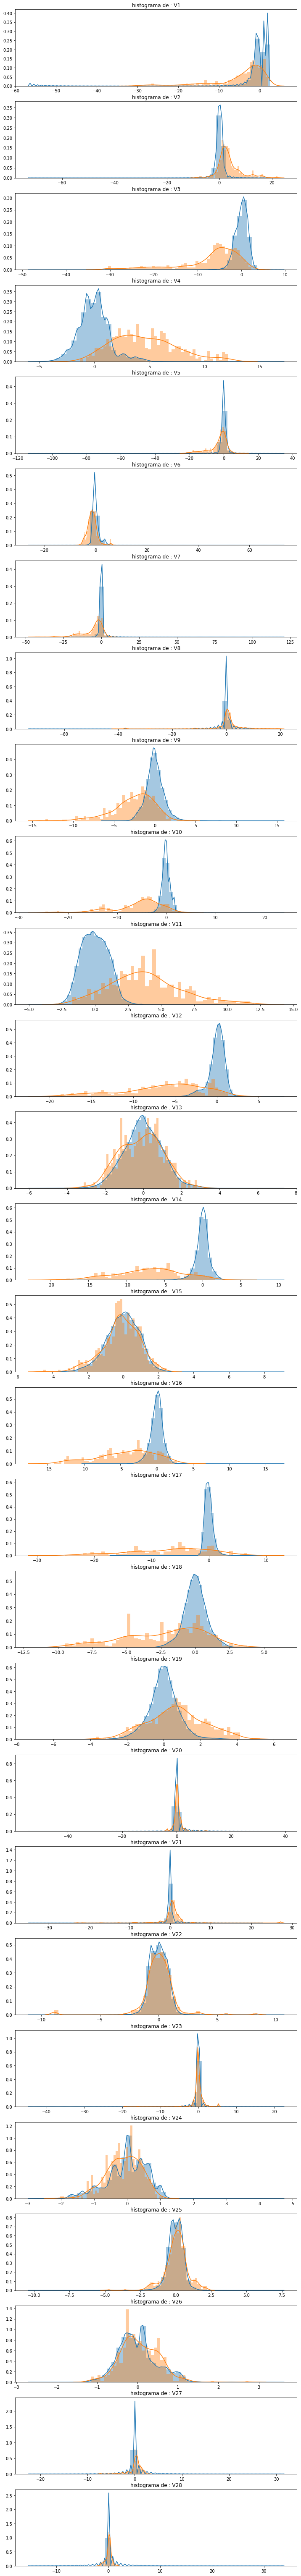

In [3]:
#Grafico de los histogramas por cada caracteristica
v_features = data.ix[:,1:29].columns

plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(data[v_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(data[cn][data.Class == 0], bins=50)
    sns.distplot(data[cn][data.Class == 1], bins=50)
    ax.set_xlabel('')
    ax.set_title('histograma de : ' + str(cn))
plt.show()

In [ ]:
#Se eliminan las caracteristicas que no se diferencian mucho entre las dos clases
data = data.drop(['V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V5','V6','V7','V8','Time','Amount'], axis =1)


In [ ]:
#Solo se utilizan las transacciones normales para ajustas Mu y Sigma
normal = data[data.Class == 0]
fraud = data[data.Class == 1]
#Separacion de los dataset en test y pruebas
X_train = normal.sample(frac = 0.6)
X_CV = pd.concat([normal.sample(frac = 0.2),fraud.sample(frac = 0.50)], axis = 0)
X_test = pd.concat([normal.sample(frac = 0.2), fraud.sample(frac = 0.50)], axis = 0)
y_train, y_cv, y_test = X_train.pop('Class'), X_CV.pop('Class'), X_test.pop('Class')

m, n = X_train.shape
normal_y = normal.pop('Class')
fraud_y = fraud.pop('Class')

<h1><center>Distribución Gaussiana Multivariable</center></h1>
<h3><center>Sólo se utilizan los datos normales para calcular $\mu$ y $\Sigma$</center></h3>
<h3><justify>Primero se ajustan los parametros $\mu$ y $\Sigma$ con los datos de las transacciones validas para encontrar las medias y la matriz de covarianza de las transacciones normales.</justify></h3>
<h2><center>$$\mu = \frac{1}{m} \sum_{i=0}^m x^i$$</center></h2>                  
<h2><center>$$\Sigma = \frac{1}{m} \sum_{i=0}^m (x^i - \mu)(x^i - \mu)^T$$</center></h2>
<h3><center>Luego para un nuevo ejemplo X, se calcula</center></h3>  
<h2>$$p(X) = \frac{1}{(2\pi)^\frac{n}{2}\left|\Sigma\right|^\frac{1}{2}}\exp{\left(-\frac{1}{2}(X - \mu)^T\Sigma^{-1}(X - \mu)\right)}$$</h2>
<h3><center>Si el valor de p(X) es menor a $\epsilon$ la transacción se marca como una anomalía</center></h3>